<a href="https://colab.research.google.com/github/misko/spf/blob/main/04_doppler_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

'''

Given some guess of the source of direction we can shift the carrier frequency
phase of received samples at the N different receivers. If the guess of the
source direction is correct, the signal from the N different receivers should
interfer constructively.

'''

c=3e8 # speed of light

class Source(object):
  def __init__(self,pos):
    self.pos=np.array(pos)

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times)+np.sin(2*np.pi*sampling_times)*1j

class SinSource(Source):
  def __init__(self,pos,frequency,phase):
    super().__init__(pos)
    self.frequency=frequency
    self.phase=phase

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times*self.frequency+self.phase)+np.sin(2*np.pi*sampling_times*self.frequency+self.phase)*1j

class NoiseWrapper(Source):
  def __init__(self,internal_source,sigma=1):
    super().__init__(internal_source.pos)
    self.internal_source=internal_source
    self.sigma=sigma

  def signal(self,sampling_times):
    return self.internal_source.signal(sampling_times) + (np.random.randn(sampling_times.shape[0], 2)*self.sigma).view(np.cdouble).reshape(-1)

class Receiver:
  def __init__(self,pos):
    self.pos=np.array(pos)

class Detector(object):
  def __init__(self,sampling_frequency):
    self.sources=[]
    self.receivers=[]
    self.sampling_frequency=sampling_frequency

  def add_source(self,source):
    self.sources.append(source)

  def rm_sources(self):
    self.sources=[]

  def add_receiver(self,receiver):
    self.receivers.append(receiver)

  def get_signal_matrix(self,start_time,duration):
    n_samples=int(duration*self.sampling_frequency)
    base_times=start_time+np.linspace(0,n_samples-1,n_samples)/self.sampling_frequency
    sample_matrix=np.zeros((len(self.receivers),n_samples),dtype=np.cdouble) # receivers x samples
    for receiver_index,receiver in enumerate(self.receivers):
      for _source in self.sources:
        time_delay=np.linalg.norm(receiver.pos-_source.pos)/c
        sample_matrix[receiver_index,:]+=_source.signal(base_times-time_delay)
    return sample_matrix

  

In [3]:
def beamformer(detector,signal_matrix,carrier_frequency):
  thetas=np.linspace(0,np.pi,90)
  steer_dot_signal=np.zeros(thetas.shape[0])
  carrier_wavelength=c/carrier_frequency
  for theta_index,theta in enumerate(thetas):
    source_vector=np.array([np.cos(theta),np.sin(theta)])
    steering_vector=np.zeros(len(detector.receivers)).astype(np.cdouble)
    projections=[]
    for receiver_index,receiver in enumerate(detector.receivers):
      projection_of_receiver_onto_source_direction=np.dot(source_vector,receiver.pos)
      projections.append(projection_of_receiver_onto_source_direction/carrier_wavelength)
      arg=2*np.pi*projection_of_receiver_onto_source_direction/carrier_wavelength
      steering_vector[receiver_index]=np.cos(-arg)+np.sin(-arg)*1j
    steer_dot_signal[theta_index]=np.absolute(np.matmul(steering_vector,signal_matrix)).mean()
  return thetas,steer_dot_signal
  

In [4]:
def plot_space(ax,d,wavelength=1):
  #fig,ax=plt.subplots(1,1,figsize=(4,4))
  receiver_pos=np.vstack(
      [ receiver.pos/wavelength for receiver in d.receivers ]
                )
  _max=receiver_pos.max()
  _min=receiver_pos.min()
  buffer=(_max-_min)*0.1
  _max+=buffer
  _min-=buffer

  center_mass=receiver_pos.mean(axis=0)

  source_vectors=[ (source.pos/wavelength-center_mass)/np.linalg.norm(source.pos/wavelength-center_mass) for source in d.sources ]

  ax.set_xlim([_min,_max])
  ax.set_ylim([_min,_max])

  ax.scatter(receiver_pos[:,0],receiver_pos[:,1],label="Receivers")
  for source_vector in source_vectors:
    ax.quiver(center_mass[0], center_mass[1], 
              -source_vector[0], -source_vector[1], scale=5, alpha=0.5,color='red',label="Source")
  ax.legend()
  ax.set_xlabel("x (wavelengths)")
  ax.set_ylabel("y (wavelengths)")
  ax.set_title("Space diagram")


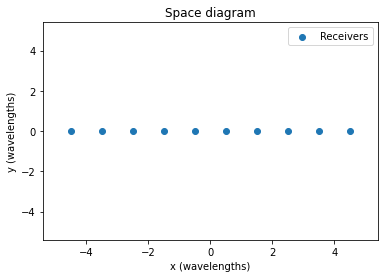

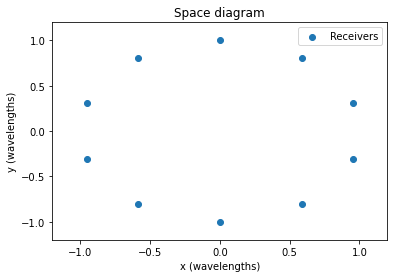

In [5]:
class ULADetector(Detector):
  def __init__(self,sampling_frequency,n_elements,spacing):
    super().__init__(sampling_frequency)
    for idx in np.arange(n_elements):
      self.add_receiver(Receiver([
          spacing*(idx-(n_elements-1)/2),
          0]))
ula_d=ULADetector(300,10,1)
fig,ax=plt.subplots(1,1)
plot_space(ax,ula_d)
      
class UCADetector(Detector):
  def __init__(self,sampling_frequency,n_elements,radius):
    super().__init__(sampling_frequency)
    for theta in np.linspace(0,2*np.pi,n_elements+1)[:-1]+np.pi/2: # orientate along y axis
      self.add_receiver(Receiver([
          radius*np.cos(theta),
          radius*np.sin(theta)]))
uca_d=UCADetector(300,10,1)
fig,ax=plt.subplots(1,1)
plot_space(ax,uca_d)

In [51]:
sin_source_frequency=12e3 # 10khz signal 
wavelength=c/sin_source_frequency
d=UCADetector(1e6,8,wavelength/2) # 1Mhz sampling

#analyze_beamformer(d,sin_source_frequency,n_intervals=15, n_repeats=5, sigma=1,plot_raw_signal=True)

theta=np.pi/6
d.add_source(NoiseWrapper(
          SinSource([
          wavelength*100000*np.cos(theta),
          wavelength*100000*np.sin(theta)],
          sin_source_frequency,0),sigma=0.0))

signal_matrix=d.get_signal_matrix(0,2000/1e6) 

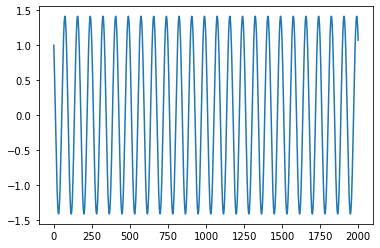

In [52]:
plt.plot(signal_matrix[0].real+signal_matrix[0].imag)

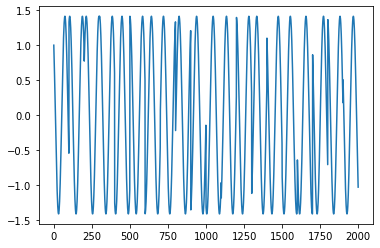

In [55]:
def doppler_sample_matrix(signal_matrix,samples_per_period):
  doppler_matrix=np.zeros(signal_matrix.shape[1]).astype(np.cdouble)
  idx=0
  while idx*samples_per_period<signal_matrix.shape[1]:
    sidx=idx*samples_per_period
    eidx=min(sidx+samples_per_period,signal_matrix.shape[1])
    doppler_matrix[sidx:eidx]=signal_matrix[idx%signal_matrix.shape[0],sidx:eidx]
    idx+=1
  return doppler_matrix
  
dpm=doppler_sample_matrix(signal_matrix,100)

plt.plot(dpm.real+dpm.imag)

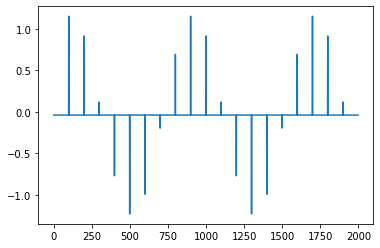

In [56]:
x = 0.5 * np.angle(dpm[0:-1] * np.conj(dpm[1:])) 
plt.plot(x)